In [2]:
import subprocess
import json
import numpy as np
from stochopy.optimize import minimize

def run_js_function(lat, long, alt, timeoffset):
    # Command to run the JavaScript script with Node.js
    command = ['node', 'eclipse_explorer_py.jsx', str(lat), str(long), str(alt), str(timeoffset)]

    # Execute the command
    result = subprocess.run(command, capture_output=True, text=True)

    # Check if the command ran successfully
    if result.returncode == 0:
        # Parse the output
        output = json.loads(result.stdout)
        return output
    else:
        # Handle errors if needed
        print("Error:", result.stderr)
        return None

# Example usage
latitude =  '10.0326'  
longitude = '-86.503695'
altitude = '0'
time_offset = '0.0'

output = run_js_function(latitude, longitude, altitude, time_offset)
print(output)


0.278


In [3]:
import scipy.optimize as opt
import scipy
import requests
import urllib
import urllib3
import pandas as pd

# Define your objective function
def calculate_magnitude(x, long, alt): # -86.5,0
    lat = x[0]
    output = run_js_function(lat, long, alt, 0)
    if output is not None and output != '':         # - for finding max using fmin
        print(x, -float(output))
        return -float(output)
    else:
        print(x, 0)
        return 0

#x = opt.fmin_l_bfgs_b(calculate_magnitude, bounds=bounds, x0=np.array([10.0326]) , args=(-86.5,0), approx_grad=True, maxiter=100, epsilon=0.5)
long = -86.5
alt = 0

# LAT: (-10, 60)
#TODO: set min magnitude to find to be 1.0 (-1); epsilon: learning rate (want big jumps, not 0.0000..., more like 1)
bounds = [[-10,60.0]]
x = opt.fmin_l_bfgs_b(calculate_magnitude, bounds=bounds, x0=np.array([10.0326]) , args=(-86.5,0), approx_grad=True, maxiter=100, epsilon=0.5)
#x = minimize(calculate_magnitude, bounds=bounds, x0=np.array([-86.5, 10.0, 250]), options={"maxiter": 2000, "popsize": 3, "seed": 42})
print(x[0][0])
print(abs(x[1]))



[10.0326] -0.277
[10.5326] -0.289
[10.0566] -0.278
[10.5566] -0.29
[10.0806] -0.279
[10.5806] -0.291
[10.1766] -0.281
[10.6766] -0.293
[10.5606] -0.29
[11.0606] -0.302
[12.0966] -0.327
[12.5966] -0.339
[18.2406] -0.478
[18.7406] -0.491
[42.8166] -0.932
[43.3166] -0.919
[30.5286] -0.795
[31.0286] -0.809
[39.58563418] -1.054
[40.08563418] -1.054
39.585634179003016
1.054


In [48]:

from scipy.optimize._differentialevolution import DifferentialEvolutionSolver

# Find the latitude with maximum obscuration for each longitude in the US
def find_max_magnitudes_coords():
    bounds = [[-10,60.0]]
    max_magnitudes_coords = []
    memo = [0]

    # Iterate over all possible longitudes in the contiguous United States
    for iter,long in enumerate(np.arange(-140, -33, 0.1)):
        print("Processing longitude:", long)
        alt = 0
        with DifferentialEvolutionSolver(calculate_magnitude, x0=[memo[-1]], args=(long,alt,), bounds=bounds, popsize=10, maxiter=200) as solver:
            for step in solver:
                step = next(solver)  # Returns a tuple of xk and func evaluation
                func_value = step[1]  # Retrieves the func evaluation
                #print(func_value)
                if solver.converged() and func_value <= -1:
                    memo.append(solver.x[0])
                    break

        s = solver.x
        best_lat = s[0]
        max_magnitude = abs(func_value)

        print("Best latitude for longitude", long, "is", best_lat, "iwith maximum magnitude of", max_magnitude)
    
        max_magnitudes_coords.append((best_lat, long, max_magnitude))
    
    return max_magnitudes_coords

max_mag_coords = find_max_magnitudes_coords()

# optimization: magnitude found should be greater than 100% (we assume there is at least one lat that casues 100%+ mag for every long)
# also, we use dynamic programming by storing each latitude and calling on previous longitude's latitude as initial guess  
# 4 hours -> 1 23 mins

Processing longitude: -140.0
[0.] -0.934
[42.7535905] -0.138
[21.82743605] -0.441
[31.96704982] -0.274
[3.06407524] -0.855
[7.71137485] -0.74
[55.1614753] -0.032
[33.83680302] -0.247
[17.47536524] -0.525
[-5.85225391] -0.951
[36.13667327] -0.216
[42.96052304] -0.136
[4.37679994] -0.822
[41.45209528] -0.153
[56.16974746] -0.026
[35.65859344] -0.223
[0.97159586] -0.909
[-1.9791929] -0.987
[34.91835861] -0.232
[10.77345885] -0.669
[17.5541824] -0.523
[-9.78311907] -0.838
[-9.85765172] -0.836
[52.15307693] -0.053
[5.82473327] -0.786
[15.2127811] -0.572
[1.13982789] -0.904
[-3.66429072] -1.046
[3.88854234] -0.834
[0.07823336] -0.932
[1.84703099] -0.886
[29.8027579] -0.306
[10.69185032] -0.671
[-2.08154783] -0.99
[-3.73429616] -1.046
[2.01711917] -0.882
[1.67202327] -0.891
[36.32386026] -0.214
[-9.34570061] -0.851
[-8.01858778] -0.889
[-8.66401112] -0.87
[-4.66812118] -0.984
[-1.2966578] -0.969
[-1.31300693] -0.969
[-2.11576118] -0.991
[-6.03672078] -0.946
[-4.35843325] -0.993
[0.02002821] -

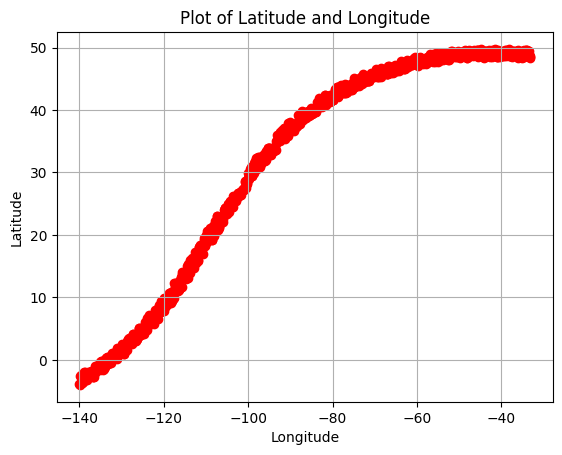

In [62]:
import matplotlib.pyplot as plt

# Extract latitude and longitude
lats = [coord[0] for coord in max_mag_coords]
longs = [coord[1] for coord in max_mag_coords]

# Plotting
plt.scatter(longs, lats, color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Latitude and Longitude')
plt.grid(True)
plt.show()



In [50]:
import csv

max_mag_coords2 = max_mag_coords.copy()
for latlong in max_mag_coords2:
    print(latlong)

csv_file = "max_mag_coords.csv"

# Write the data to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write each tuple as a row
    for row in max_mag_coords2:
        writer.writerow(row)

print("CSV file has been created successfully.")


(-3.807539838600615, -140.0, 1.046)
(-2.5591001354458953, -139.9, 1.046)
(-4.015037696553428, -139.8, 1.046)
(-2.3599383584402887, -139.70000000000002, 1.046)
(-3.4698418997985847, -139.60000000000002, 1.046)
(-3.7447255888467303, -139.50000000000003, 1.046)
(-3.7447255888467303, -139.40000000000003, 1.046)
(-2.4774905637560742, -139.30000000000004, 1.046)
(-2.4071966558459543, -139.20000000000005, 1.046)
(-3.5874818821901826, -139.10000000000005, 1.046)
(-3.3866681253461515, -139.00000000000006, 1.046)
(-2.015142487592154, -138.90000000000006, 1.047)
(-2.0151424875921506, -138.80000000000007, 1.047)
(-2.3122864702445725, -138.70000000000007, 1.047)
(-2.16827309785387, -138.60000000000008, 1.047)
(-2.3355898374433863, -138.50000000000009, 1.047)
(-2.373461803067272, -138.4000000000001, 1.047)
(-2.613502561957695, -138.3000000000001, 1.047)
(-2.3348069483329574, -138.2000000000001, 1.047)
(-3.2127786902718967, -138.1000000000001, 1.047)
(-1.987633269257465, -138.0000000000001, 1.047)
(-

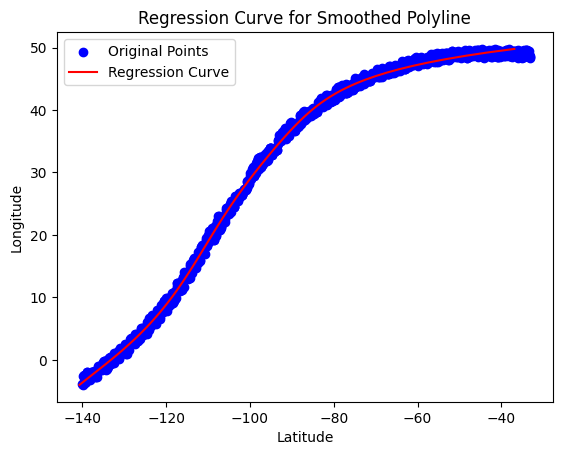

[-140.67005599 -139.66670513 -138.64613689 -137.61673088 -136.58557433
 -135.55860522 -134.54074354 -133.53601114 -132.54764102 -131.57817649
 -130.62956105 -129.70321938 -128.8001301  -127.9208909  -127.06577647
 -126.23478992 -125.42770795 -124.64412057 -123.8834655  -123.14505797
 -122.42811619 -121.731783   -121.05514397 -120.39724248 -119.75709201
 -119.13368599 -118.52600569 -117.93302613 -117.35372066 -116.78706418
 -116.2320354  -115.68761833 -115.15280321 -114.62658704 -114.10797388
 -113.59597519 -113.08961014 -112.58790619 -112.0898999  -111.59463817
 -111.10117985 -110.6085979  -110.11598192 -109.62244129 -109.12710876
 -108.62914445 -108.12774027 -107.62212472 -107.11156783 -106.59538632
 -106.07294873 -105.54368041 -105.00706823 -104.4626648  -103.910092
 -103.34904365 -102.779287   -102.20066288 -101.61308414 -101.0165322
 -100.41105127  -99.79674003  -99.17374035  -98.5422227   -97.90236788
  -97.25434469  -96.59828303  -95.93424205  -95.26217299  -94.58187599
  -93.892

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# TODO: distance to -1 is now objective function
# -1 is what alg tries to look for (the highest, and lowest lat)

# next first guess should be previous best lat   

# Transform the data to make it suitable for polynomial regression
X = np.array(lats)
y = np.array(longs)

# Choose the degree of the polynomial (you can experiment with different degrees)
degree = 8

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X[:, np.newaxis])

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict longitudes for a smoother curve
X_pred = np.linspace(min(lats), max(lats), 100)
X_pred_poly = poly_features.transform(X_pred[:, np.newaxis])
y_pred = model.predict(X_pred_poly)

# Plot the original data points
plt.scatter(longs, lats, color='blue', label='Original Points')

# Plot the regression curve
plt.plot(y_pred, X_pred, color='red', label='Regression Curve')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Regression Curve for Smoothed Polyline')
plt.legend()
plt.show()

print(y_pred)
print(X_pred)


In [75]:
def convert_to_latlng(data):
    points = data.split(", ")
    latlng_list = []
    for point in points:
        lat, long, alt = map(float, point.split())
        latlng_list.append(f"LatLng({long}, {lat}),")
    return latlng_list

data = '-157.468246 -8.333957 0.0, -156.573633 -8.206773 0.0, -156.034976 -8.126292 0.0, -155.612045 -8.060984 0.0, -155.252825 -8.004029 0.0, -154.935456 -7.952562 0.0, -154.648291 -7.905058 0.0, -154.38425 -7.860587 0.0, -154.138652 -7.818537 0.0, -153.908208 -7.778476 0.0, -153.690504 -7.740088 0.0, -153.483706 -7.703133 0.0, -153.286381 -7.667422 0.0, -153.097387 -7.632807 0.0, -152.915791 -7.599164 0.0, -152.740825 -7.566393 0.0, -152.571844 -7.534409 0.0, -152.408302 -7.503141 0.0, -152.24973 -7.472528 0.0, -152.095725 -7.442515 0.0, -151.945932 -7.413058 0.0, -151.800044 -7.384115 0.0, -151.657786 -7.355651 0.0, -151.518917 -7.327634 0.0, -151.383218 -7.300035 0.0, -151.250496 -7.272828 0.0, -151.120574 -7.245991 0.0, -150.993294 -7.219503 0.0, -150.868511 -7.193345 0.0, -150.746094 -7.1675 0.0, -150.625922 -7.141951 0.0, -150.507884 -7.116684 0.0, -150.391878 -7.091686 0.0, -150.277811 -7.066944 0.0, -150.165594 -7.042448 0.0, -150.055149 -7.018185 0.0, -149.946399 -6.994148 0.0, -149.839275 -6.970326 0.0, -149.733712 -6.94671 0.0, -149.629648 -6.923293 0.0, -149.527027 -6.900068 0.0, -149.425795 -6.877027 0.0, -149.325901 -6.854164 0.0, -149.227299 -6.831472 0.0, -149.129944 -6.808945 0.0, -149.033794 -6.786579 0.0, -148.938808 -6.764367 0.0, -148.84495 -6.742305 0.0, -148.752183 -6.720388 0.0, -148.660474 -6.698612 0.0, -148.56979 -6.676973 0.0, -148.480102 -6.655466 0.0, -148.391379 -6.634087 0.0, -148.303595 -6.612834 0.0, -148.216722 -6.591702 0.0, -148.130737 -6.570688 0.0, -148.045614 -6.549789 0.0, -147.961332 -6.529002 0.0, -147.877867 -6.508325 0.0, -147.795199 -6.487753 0.0, -147.713308 -6.467286 0.0, -147.632174 -6.446919 0.0, -147.551779 -6.426651 0.0, -147.472105 -6.40648 0.0, -147.393135 -6.386403 0.0, -147.314853 -6.366417 0.0, -147.237243 -6.346522 0.0, -147.16029 -6.326715 0.0, -147.083978 -6.306993 0.0, -147.008295 -6.287356 0.0, -146.933225 -6.2678 0.0, -146.858758 -6.248326 0.0, -146.784878 -6.22893 0.0, -146.711576 -6.209612 0.0, -146.638837 -6.190369 0.0, -146.566652 -6.171201 0.0, -146.49501 -6.152105 0.0, -146.423898 -6.133081 0.0, -146.353308 -6.114127 0.0, -146.28323 -6.095241 0.0, -146.213652 -6.076423 0.0, -146.144567 -6.057671 0.0, -146.075965 -6.038984 0.0, -146.007838 -6.020361 0.0, -145.940176 -6.0018 0.0, -145.872972 -5.983302 0.0, -145.806217 -5.964863 0.0, -145.739903 -5.946485 0.0, -145.674024 -5.928164 0.0, -145.608571 -5.909901 0.0, -145.543538 -5.891695 0.0, -145.478917 -5.873545 0.0, -145.414702 -5.855449 0.0, -145.350886 -5.837407 0.0, -145.287462 -5.819418 0.0, -145.224426 -5.801482 0.0, -145.161769 -5.783596 0.0, -145.099487 -5.765762 0.0, -145.037573 -5.747977 0.0, -144.976023 -5.730241 0.0, -144.914829 -5.712554 0.0, -144.853988 -5.694914 0.0, -144.793494 -5.677322 0.0, -144.733342 -5.659776 0.0, -144.673527 -5.642275 0.0, -144.614043 -5.624819 0.0, -144.554887 -5.607408 0.0, -144.496054 -5.590041 0.0, -144.437538 -5.572716 0.0, -144.379337 -5.555435 0.0, -144.321444 -5.538195 0.0, -144.263857 -5.520997 0.0, -144.206571 -5.503839 0.0, -144.149582 -5.486722 0.0, -144.092886 -5.469645 0.0, -144.036479 -5.452608 0.0, -143.980358 -5.435609 0.0, -143.924518 -5.418648 0.0, -143.868957 -5.401726 0.0, -143.81367 -5.38484 0.0, -143.758654 -5.367992 0.0, -143.703906 -5.35118 0.0, -143.649422 -5.334405 0.0, -143.5952 -5.317665 0.0, -143.541236 -5.30096 0.0, -143.487526 -5.28429 0.0, -143.434068 -5.267654 0.0, -143.380859 -5.251052 0.0, -143.327896 -5.234484 0.0, -143.275176 -5.217949 0.0, -143.222696 -5.201447 0.0, -143.170454 -5.184977 0.0, -143.118446 -5.16854 0.0, -143.06667 -5.152134 0.0, -143.015124 -5.13576 0.0, -142.963804 -5.119417 0.0, -142.912708 -5.103104 0.0, -142.861835 -5.086822 0.0, -142.81118 -5.07057 0.0, -142.760743 -5.054348 0.0, -142.71052 -5.038155 0.0, -142.66051 -5.021991 0.0, -142.61071 -5.005857 0.0, -142.561117 -4.98975 0.0, -142.51173 -4.973672 0.0, -142.462547 -4.957622 0.0, -142.413565 -4.9416 0.0, -142.364782 -4.925605 0.0, -142.316197 -4.909637 0.0, -142.267807 -4.893696 0.0, -142.21961 -4.877782 0.0, -142.171605 -4.861894 0.0, -142.123789 -4.846032 0.0, -142.07616 -4.830196 0.0, -142.028718 -4.814386 0.0, -141.981459 -4.798601 0.0, -141.934382 -4.782841 0.0, -141.887486 -4.767106 0.0, -141.840768 -4.751396 0.0, -141.794228 -4.73571 0.0, -141.747862 -4.720048 0.0, -141.701671 -4.70441 0.0, -141.655651 -4.688797 0.0, -141.609802 -4.673206 0.0, -141.564121 -4.657639 0.0, -141.518608 -4.642095 0.0, -141.47326 -4.626575 0.0, -141.428077 -4.611077 0.0, -141.383057 -4.595601 0.0, -141.338197 -4.580148 0.0, -141.293498 -4.564717 0.0, -141.248957 -4.549308 0.0, -141.204573 -4.53392 0.0, -141.160345 -4.518555 0.0, -141.116271 -4.50321 0.0, -141.07235 -4.487887 0.0, -141.028581 -4.472586 0.0, -140.984962 -4.457305 0.0, -140.941493 -4.442044 0.0, -140.898171 -4.426804 0.0, -140.854995 -4.411585 0.0, -140.811965 -4.396386 0.0, -140.769079 -4.381207 0.0, -140.726336 -4.366048 0.0, -140.683735 -4.350908 0.0, -140.641275 -4.335789 0.0, -140.598953 -4.320688 0.0, -140.556771 -4.305607 0.0, -140.514725 -4.290545 0.0, -140.472815 -4.275502 0.0, -140.431041 -4.260478 0.0, -140.3894 -4.245473 0.0, -140.347893 -4.230486 0.0, -140.306517 -4.215517 0.0, -140.265272 -4.200567 0.0, -140.224157 -4.185635 0.0, -140.18317 -4.170721 0.0, -140.142311 -4.155825 0.0, -140.10158 -4.140947 0.0, -140.060974 -4.126086 0.0, -140.020493 -4.111243 0.0, -139.980135 -4.096417 0.0, -139.939901 -4.081608 0.0, -139.899789 -4.066817 0.0, -139.859798 -4.052042 0.0, -139.819928 -4.037285 0.0, -139.780176 -4.022544 0.0, -139.740544 -4.00782 0.0, -139.701029 -3.993112 0.0, -139.661631 -3.978421 0.0, -139.622348 -3.963746 0.0, -139.583181 -3.949087 0.0, -139.544128 -3.934444 0.0, -139.505189 -3.919818 0.0, -139.466362 -3.905207 0.0, -139.427648 -3.890611 0.0, -139.389044 -3.876032 0.0, -139.35055 -3.861468 0.0, -139.312167 -3.846919 0.0, -139.273892 -3.832386 0.0, -139.235724 -3.817868 0.0, -139.197665 -3.803366 0.0, -139.159712 -3.788878 0.0, -139.121864 -3.774405 0.0, -139.084122 -3.759947 0.0, -139.046484 -3.745504 0.0, -139.00895 -3.731075 0.0, -138.971519 -3.716661 0.0, -138.93419 -3.702262 0.0, -138.896963 -3.687876 0.0, -138.859836 -3.673505 0.0, -138.82281 -3.659149 0.0, -138.785884 -3.644806 0.0, -138.749057 -3.630478 0.0, -138.712328 -3.616163 0.0, -138.675697 -3.601862 0.0, -138.639162 -3.587575 0.0, -138.602725 -3.573302 0.0, -138.566383 -3.559042 0.0, -138.530136 -3.544796 0.0, -138.493984 -3.530563 0.0, -138.457926 -3.516344 0.0, -138.421961 -3.502137 0.0, -138.386089 -3.487945 0.0, -138.35031 -3.473765 0.0, -138.314622 -3.459598 0.0, -138.279025 -3.445444 0.0, -138.243519 -3.431303 0.0, -138.208103 -3.417175 0.0, -138.172776 -3.40306 0.0, -138.137538 -3.388957 0.0, -138.102389 -3.374867 0.0, -138.067327 -3.360789 0.0, -138.032353 -3.346724 0.0, -137.997466 -3.332671 0.0, -137.962664 -3.318631 0.0, -137.927949 -3.304602 0.0, -137.893319 -3.290586 0.0, -137.858773 -3.276582 0.0, -137.824312 -3.262591 0.0, -137.789934 -3.248611 0.0, -137.75564 -3.234643 0.0, -137.721428 -3.220686 0.0, -137.687299 -3.206742 0.0, -137.653252 -3.192809 0.0, -137.619286 -3.178888 0.0, -137.5854 -3.164979 0.0, -137.551596 -3.151081 0.0, -137.517871 -3.137194 0.0, -137.484225 -3.123319 0.0, -137.450659 -3.109456 0.0, -137.417171 -3.095603 0.0, -137.383762 -3.081762 0.0, -137.35043 -3.067932 0.0, -137.317175 -3.054113 0.0, -135.894383 -2.442892 0.0, -134.595768 -1.849775 0.0, -133.398408 -1.271644 0.0, -132.285538 -0.706204 0.0, -131.24445 -0.151707 0.0, -130.265241 0.393218 0.0, -129.340008 0.929671 0.0, -128.462325 1.458552 0.0, -127.62688 1.980609 0.0, -126.829222 2.496473 0.0, -126.065573 3.006682 0.0, -125.332694 3.5117 0.0, -124.627781 4.011931 0.0, -123.948387 4.50773 0.0, -123.292357 4.999411 0.0, -122.657785 5.487253 0.0, -122.04297 5.971505 0.0, -121.446389 6.452393 0.0, -120.866667 6.930121 0.0, -120.302561 7.404875 0.0, -119.752939 7.876823 0.0, -119.216764 8.34612 0.0, -118.693088 8.812911 0.0, -118.181035 9.277325 0.0, -117.679797 9.739487 0.0, -117.188623 10.199509 0.0, -116.706813 10.657496 0.0, -116.233715 11.113548 0.0, -115.768717 11.567757 0.0, -115.311244 12.02021 0.0, -114.860754 12.470987 0.0, -114.416734 12.920167 0.0, -113.978699 13.367821 0.0, -113.546187 13.814018 0.0, -113.118758 14.258822 0.0, -112.695992 14.702296 0.0, -112.277484 15.144497 0.0, -111.862848 15.585482 0.0, -111.451712 16.025302 0.0, -111.043714 16.464009 0.0, -110.638506 16.90165 0.0, -110.235749 17.338271 0.0, -109.835115 17.773916 0.0, -109.436283 18.208627 0.0, -109.038938 18.642444 0.0, -108.642774 19.075405 0.0, -108.247487 19.507547 0.0, -107.852781 19.938906 0.0, -107.458362 20.369514 0.0, -107.063939 20.799404 0.0, -106.669224 21.228607 0.0, -106.273932 21.657152 0.0, -105.877776 22.085068 0.0, -105.480473 22.512381 0.0, -105.081738 22.939117 0.0, -104.681285 23.3653 0.0, -104.278827 23.790955 0.0, -103.874075 24.216102 0.0, -103.466739 24.640763 0.0, -103.056523 25.064958 0.0, -102.643129 25.488704 0.0, -102.226255 25.91202 0.0, -101.805591 26.334921 0.0, -101.380824 26.757422 0.0, -100.951635 27.179536 0.0, -100.517694 27.601277 0.0, -100.078668 28.022654 0.0, -99.63421 28.443677 0.0, -99.183967 28.864353 0.0, -98.727575 29.28469 0.0, -98.264658 29.704692 0.0, -97.794827 30.124361 0.0, -97.31768 30.5437 0.0, -96.8328 30.962707 0.0, -96.339755 31.381379 0.0, -95.838095 31.799711 0.0, -95.327352 32.217697 0.0, -94.807038 32.635325 0.0, -94.276641 33.052583 0.0, -93.735628 33.469456 0.0, -93.18344 33.885925 0.0, -92.61949 34.301967 0.0, -92.043159 34.717556 0.0, -91.453798 35.132663 0.0, -90.850722 35.547252 0.0, -90.233206 35.961283 0.0, -89.600483 36.374712 0.0, -88.951741 36.787488 0.0, -88.286117 37.199554 0.0, -87.602692 37.610844 0.0, -86.900487 38.021286 0.0, -86.178455 38.430798 0.0, -85.435476 38.83929 0.0, -84.670349 39.246657 0.0, -83.881778 39.652787 0.0, -83.068371 40.057549 0.0, -82.228619 40.460801 0.0, -81.360887 40.862378 0.0, -80.463396 41.262101 0.0, -79.534206 41.659763 0.0, -78.57119 42.055134 0.0, -77.572012 42.447953 0.0, -76.534091 42.837923 0.0, -75.454566 43.224709 0.0, -74.330246 43.607926 0.0, -73.157555 43.987136 0.0, -71.932457 44.361831 0.0, -70.65037 44.731426 0.0, -69.306043 45.09524 0.0, -67.893415 45.452471 0.0, -66.405409 45.802173 0.0, -64.833668 46.143215 0.0, -63.168193 46.474226 0.0, -61.396816 46.793527 0.0, -59.50446 47.099025 0.0, -57.471999 47.388051 0.0, -55.274482 47.657115 0.0, -52.878191 47.901501 0.0, -50.235416 48.114552 0.0, -50.173402 48.118862 0.0, -50.111231 48.123153 0.0, -50.048902 48.127423 0.0, -49.986416 48.131672 0.0, -49.923769 48.135901 0.0, -49.860963 48.140109 0.0, -49.797995 48.144296 0.0, -49.734865 48.148462 0.0, -49.671572 48.152607 0.0, -49.608113 48.15673 0.0, -49.54449 48.160831 0.0, -49.4807 48.164911 0.0, -49.416742 48.168969 0.0, -49.352615 48.173005 0.0, -49.288319 48.177019 0.0, -49.223851 48.181011 0.0, -49.159212 48.18498 0.0, -49.094399 48.188926 0.0, -49.029411 48.19285 0.0, -48.964248 48.196751 0.0, -48.898909 48.200628 0.0, -48.833391 48.204482 0.0, -48.767694 48.208313 0.0, -48.701816 48.21212 0.0, -48.635757 48.215904 0.0, -48.569515 48.219663 0.0, -48.503089 48.223399 0.0, -48.436477 48.22711 0.0, -48.369678 48.230796 0.0, -48.302692 48.234458 0.0, -48.235515 48.238095 0.0, -48.168148 48.241706 0.0, -48.100589 48.245293 0.0, -48.032836 48.248854 0.0, -47.964888 48.25239 0.0, -47.896744 48.255899 0.0, -47.828402 48.259383 0.0, -47.75986 48.26284 0.0, -47.691118 48.266271 0.0, -47.622173 48.269676 0.0, -47.553025 48.273053 0.0, -47.483671 48.276404 0.0, -47.41411 48.279727 0.0, -47.344341 48.283023 0.0, -47.274362 48.286291 0.0, -47.204171 48.289531 0.0, -47.133767 48.292742 0.0, -47.063148 48.295926 0.0, -46.992312 48.299081 0.0, -46.921258 48.302207 0.0, -46.849984 48.305304 0.0, -46.778487 48.308371 0.0, -46.706768 48.311409 0.0, -46.634822 48.314417 0.0, -46.56265 48.317396 0.0, -46.490248 48.320343 0.0, -46.417615 48.323261 0.0, -46.34475 48.326147 0.0, -46.271649 48.329002 0.0, -46.198312 48.331826 0.0, -46.124736 48.334618 0.0, -46.050919 48.337378 0.0, -45.97686 48.340106 0.0, -45.902555 48.342802 0.0, -45.828003 48.345464 0.0, -45.753203 48.348094 0.0, -45.67815 48.35069 0.0, -45.602845 48.353253 0.0, -45.527283 48.355781 0.0, -45.451464 48.358276 0.0, -45.375384 48.360735 0.0, -45.299041 48.36316 0.0, -45.222433 48.365549 0.0, -45.145558 48.367903 0.0, -45.068413 48.370221 0.0, -44.990995 48.372503 0.0, -44.913302 48.374748 0.0, -44.835332 48.376956 0.0, -44.757081 48.379127 0.0, -44.678548 48.38126 0.0, -44.599729 48.383354 0.0, -44.520622 48.385411 0.0, -44.441224 48.387429 0.0, -44.361532 48.389407 0.0, -44.281543 48.391346 0.0, -44.201254 48.393245 0.0, -44.120663 48.395103 0.0, -44.039766 48.396921 0.0, -43.95856 48.398697 0.0, -43.877042 48.400432 0.0, -43.795209 48.402124 0.0, -43.713057 48.403774 0.0, -43.630584 48.405381 0.0, -43.547785 48.406945 0.0, -43.464658 48.408465 0.0, -43.381199 48.40994 0.0, -43.297404 48.41137 0.0, -43.21327 48.412755 0.0, -43.128794 48.414094 0.0, -43.04397 48.415386 0.0, -42.958796 48.416632 0.0, -42.873268 48.41783 0.0, -42.787381 48.418981 0.0, -42.701131 48.420082 0.0, -42.614515 48.421135 0.0, -42.527529 48.422137 0.0, -42.440167 48.42309 0.0, -42.352425 48.423992 0.0, -42.2643 48.424842 0.0, -42.175786 48.42564 0.0, -42.086879 48.426385 0.0, -41.997574 48.427077 0.0, -41.907866 48.427715 0.0, -41.81775 48.428298 0.0, -41.727221 48.428826 0.0, -41.636275 48.429298 0.0, -41.544905 48.429713 0.0, -41.453106 48.43007 0.0, -41.360873 48.430369 0.0, -41.268201 48.430609 0.0, -41.175082 48.430789 0.0, -41.081513 48.430908 0.0, -40.987485 48.430966 0.0, -40.892994 48.430962 0.0, -40.798033 48.430895 0.0, -40.702596 48.430763 0.0, -40.606675 48.430567 0.0, -40.510265 48.430304 0.0, -40.413357 48.429975 0.0, -40.315946 48.429579 0.0, -40.218024 48.429113 0.0, -40.119583 48.428578 0.0, -40.020616 48.427972 0.0, -39.921115 48.427294 0.0, -39.821071 48.426543 0.0, -39.720478 48.425719 0.0, -39.619325 48.424819 0.0, -39.517605 48.423843 0.0, -39.415309 48.422789 0.0, -39.312427 48.421656 0.0, -39.20895 48.420444 0.0, -39.104869 48.41915 0.0, -39.000173 48.417773 0.0, -38.894852 48.416313 0.0, -38.788896 48.414767 0.0, -38.682294 48.413134 0.0, -38.575035 48.411412 0.0, -38.467107 48.409601 0.0, -38.358499 48.407698 0.0, -38.249198 48.405702 0.0, -38.139193 48.403611 0.0, -38.028469 48.401423 0.0, -37.917014 48.399137 0.0, -37.804814 48.396751 0.0, -37.691854 48.394262 0.0, -37.578121 48.39167 0.0, -37.463599 48.388971 0.0, -37.348272 48.386164 0.0, -37.232125 48.383247 0.0, -37.11514 48.380217 0.0, -36.9973 48.377072 0.0, -36.878588 48.373809 0.0, -36.758984 48.370427 0.0, -36.63847 48.366922 0.0, -36.517025 48.363292 0.0, -36.39463 48.359534 0.0, -36.271261 48.355646 0.0, -36.146898 48.351623 0.0, -36.021516 48.347464 0.0, -35.895092 48.343164 0.0, -35.767601 48.338721 0.0, -35.639016 48.334131 0.0, -35.50931 48.329391 0.0, -35.378455 48.324495 0.0, -35.246421 48.319442 0.0, -35.113178 48.314226 0.0, -34.978692 48.308843 0.0, -34.84293 48.303288 0.0, -34.705856 48.297558 0.0, -34.567434 48.291646 0.0, -34.427624 48.285548 0.0, -34.286386 48.279258 0.0, -34.143677 48.272771 0.0, -33.999451 48.26608 0.0, -33.853661 48.25918 0.0, -33.706257 48.252062 0.0, -33.557186 48.244722 0.0, -33.406392 48.23715 0.0, -33.253817 48.229339 0.0, -33.099398 48.221281 0.0, -32.943068 48.212967 0.0, -32.784757 48.204387 0.0, -32.62439 48.195532 0.0, -32.461888 48.186391 0.0, -32.297165 48.176953 0.0, -32.130131 48.167205 0.0, -31.960688 48.157135 0.0, -31.788732 48.146729 0.0, -31.614151 48.135971 0.0, -31.436824 48.124846 0.0, -31.256619 48.113336 0.0, -31.073397 48.101423 0.0, -30.887003 48.089086 0.0, -30.697271 48.076303 0.0, -30.504019 48.06305 0.0, -30.307047 48.049301 0.0, -30.106137 48.035025 0.0, -29.901047 48.020192 0.0, -29.691509 48.004766 0.0, -29.477227 47.988708 0.0, -29.257868 47.971972 0.0, -29.03306 47.954511 0.0, -28.802381 47.936267 0.0, -28.565353 47.917179 0.0, -28.321429 47.897172 0.0, -28.069977 47.876164 0.0, -27.810262 47.854058 0.0, -27.541424 47.830738 0.0, -27.262436 47.80607 0.0, -26.972068 47.779891 0.0, -26.668814 47.752001 0.0, -26.350807 47.722153 0.0, -26.015676 47.690034 0.0, -25.660335 47.655236 0.0, -25.280644 47.617212 0.0, -24.870815 47.575196 0.0, -24.422323 47.528062 0.0, -23.921644 47.474022 0.0, -23.344848 47.409917 0.0, -22.640979 47.329012 0.0, -21.647125 47.209774 0.0'
latlng_points = convert_to_latlng(data)
for point in latlng_points:
    print(point)

LatLng(-8.333957, -157.468246),
LatLng(-8.206773, -156.573633),
LatLng(-8.126292, -156.034976),
LatLng(-8.060984, -155.612045),
LatLng(-8.004029, -155.252825),
LatLng(-7.952562, -154.935456),
LatLng(-7.905058, -154.648291),
LatLng(-7.860587, -154.38425),
LatLng(-7.818537, -154.138652),
LatLng(-7.778476, -153.908208),
LatLng(-7.740088, -153.690504),
LatLng(-7.703133, -153.483706),
LatLng(-7.667422, -153.286381),
LatLng(-7.632807, -153.097387),
LatLng(-7.599164, -152.915791),
LatLng(-7.566393, -152.740825),
LatLng(-7.534409, -152.571844),
LatLng(-7.503141, -152.408302),
LatLng(-7.472528, -152.24973),
LatLng(-7.442515, -152.095725),
LatLng(-7.413058, -151.945932),
LatLng(-7.384115, -151.800044),
LatLng(-7.355651, -151.657786),
LatLng(-7.327634, -151.518917),
LatLng(-7.300035, -151.383218),
LatLng(-7.272828, -151.250496),
LatLng(-7.245991, -151.120574),
LatLng(-7.219503, -150.993294),
LatLng(-7.193345, -150.868511),
LatLng(-7.1675, -150.746094),
LatLng(-7.141951, -150.625922),
LatLng(-7.11